# Processing Algoseek's Trade & Quote Minute Bar data

In this notebook, we load the high-quality NASDAQ100 minute-bar trade-and-quote data generously provided by [Algoseek](https://www.algoseek.com/) (available [here](https://www.algoseek.com/ml4t-book-data.html)) that we will use in [Chapter 12](../../12_gradient_boosting_machines) to develop an intraday trading strategy. 

## Imports & Settings

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Algoseek Trade & Quote Minute Bar Data

### Data Dictionary

The Quote fields are based on changes to the NBBO ([National Best Bid Offer](https://www.investopedia.com/terms/n/nbbo.asp)) from the top-of-book price and size from
each of the exchanges.

The enhanced Trade & Quote bar fields include the following fields:
- **Field**: Name of Field.
- **Q / T**: Field based on Quotes or Trades
- **Type**: Field format
- **No Value**: Value of field when there is no value or data. 
  - Note: “Never” means field should always have a value EXCEPT for the first bar of the day.
- **Description**: Description of the field.

| id  | Field                   | Q/T  | Type                          |  No Value | Description                                                                                                                                                                                                         |
|:---:|:------------------------|:----:|:------------------------------|:---------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1  | `Date`                   |      | YYYYMMDD                      | Never     | Trade Date                                                                                                                                                                                                          |
| 2  | `Ticker`                 |      | String                       | Never      | Ticker Symbol                                                                                                                                                                                                       |
| 3  | `TimeBarStart`           |      | HHMM <br>HHMMSS <br>HHMMSSMMM | Never     | For minute bars: HHMM. <br>For second bars: HHMMSS. <br>Examples<br>- One second bar 130302 is from time greater than 130301 to 130302.<br>- One minute bar 1104 is from time greater than 1103 to 1104. |
| 4  | `OpenBarTime`            | Q    | HHMMSSMMM                    | Never      | Open Time of the Bar, for example one minute:<br>11:03:00.000                                                                                                                                                       |
| 5  | `OpenBidPrice`           | Q    | Number                        | Never     | NBBO Bid Price as of bar Open                                                                                                                                                                                       |
| 6  | `OpenBidSize`            | Q    | Number                        | Never     | Total Size from all Exchanges with<br>OpenBidPrice                                                                                                                                                                  |
| 7  | `OpenAskPrice`           | Q    | Number                        | Never     | NBBO Ask Price as of bar Open                                                                                                                                                                                       |
| 8  | `OpenAskSize`            | Q    | Number                        | Never     | Total Size from all Exchange with<br>OpenAskPrice                                                                                                                                                                   |
| 9  | `FirstTradeTime`         | T    | HHMMSSMMM                     | Blank     | Time of first Trade                                                                                                                                                                                                 |
| 10 | `FirstTradePrice`        | T    | Number                        | Blank     | Price of first Trade                                                                                                                                                                                                |
| 11 | `FirstTradeSize`         | T    | Number                        | Blank     | Number of shares of first trade                                                                                                                                                                                     |
| 12 | `HighBidTime`            | Q    | HHMMSSMMM                     | Never     | Time of highest NBBO Bid Price                                                                                                                                                                                      |
| 13 | `HighBidPrice`           | Q    | Number                        | Never     | Highest NBBO Bid Price                                                                                                                                                                                              |
| 14 | `HighBidSize`            | Q    | Number                        | Never     | Total Size from all Exchanges with HighBidPrice                                                                                                                                                                  |
| 15 | `AskPriceAtHighBidPrice` | Q    | Number                        | Never     | Ask Price at time of Highest Bid Price                                                                                                                                                                              |
| 16 | `AskSizeAtHighBidPrice`  | Q    | Number                        | Never     | Total Size from all Exchanges with `AskPriceAtHighBidPrice`                                                                                                                                                        |
| 17 | `HighTradeTime`          | T    | HHMMSSMMM                     | Blank     | Time of Highest Trade                                                                                                                                                                                               |
| 18 | `HighTradePrice`         | T    | Number                        | Blank     | Price of highest Trade                                                                                                                                                                                              |
| 19 | `HighTradeSize`          | T    | Number                        | Blank     | Number of shares of highest trade                                                                                                                                                                                   |
| 20 | `LowBidTime`             | Q    | HHMMSSMMM                     | Never     | Time of lowest Bid                                                                                                                                                                                                  |
| 21 | `LowBidPrice`            | Q    | Number                        | Never     | Lowest NBBO Bid price of bar.                                                                                                                                                                                       |
| 22 | `LowBidSize`             | Q    | Number                        | Never     | Total Size from all Exchanges with `LowBidPrice`                                                                                                                                                                   |
| 23 | `AskPriceAtLowBidPrice`  | Q    | Number                        | Never     | Ask Price at lowest Bid price                                                                                                                                                                                       |
| 24  | `AskSizeAtLowBidPrice`  | Q    | Number                        | Never     | Total Size from all Exchanges with `AskPriceAtLowBidPrice`                                                                                                                                                                                       |
| 25  | `LowTradeTime`          | T    | HHMMSSMMM                     | Blank     | Time of lowest Trade                                                                                                                                                                                                                             |
| 26  | `LowTradePrice`         | T    | Number                        | Blank     | Price of lowest Trade                                                                                                                                                                                                                            |
| 27  | `LowTradeSize`          | T    | Number                        | Blank     | Number of shares of lowest trade                                                                                                                                                                                                                 |
| 28  | `CloseBarTime`          | Q    | HHMMSSMMM                     | Never     | Close Time of the Bar, for example one minute: 11:03:59.999                                                                                                                                                                                      |
| 29  | `CloseBidPrice`         | Q    | Number                        | Never     | NBBO Bid Price at bar Close                                                                                                                                                                                                                      |
| 30  | `CloseBidSize`          | Q    | Number                        | Never     | Total Size from all Exchange with `CloseBidPrice`                                                                                                                                                                                                |
| 31  | `CloseAskPrice`         | Q    | Number                        | Never     | NBBO Ask Price at bar Close                                                                                                                                                                                                                      |
| 32  | `CloseAskSize`          | Q    | Number                        | Never     | Total Size from all Exchange with `CloseAskPrice`                                                                                                                                                                                                |
| 33  | `LastTradeTime`         | T    | HHMMSSMMM                     | Blank     | Time of last Trade                                                                                                                                                                                                                               |
| 34  | `LastTradePrice`        | T    | Number                        | Blank     | Price of last Trade                                                                                                                                                                                                                              |
| 35  | `LastTradeSize`         | T    | Number                        | Blank     | Number of shares of last trade                                                                                                                                                                                                                   |
| 36  | `MinSpread`             | Q    | Number                        | Never     | Minimum Bid-Ask spread size. This may be 0 if the market was crossed during the bar.<br/>If negative spread due to back quote, make it 0.                                                                                                            |
| 37  | `MaxSpread`             | Q    | Number                        | Never     | Maximum Bid-Ask spread in bar                                                                                                                                                                                                                    |
| 38  | `CancelSize`            | T    | Number                        | 0         | Total shares canceled. Default=blank                                                                                                                                                                                                             |
| 39  | `VolumeWeightPrice`     | T    | Number                        | Blank     | Trade Volume weighted average price <br>Sum((`Trade1Shares`*`Price`)+(`Trade2Shares`*`Price`)+…)/`TotalShares`. <br>Note: Blank if no trades.                                                                                                        |
| 40  | `NBBOQuoteCount`        | Q    | Number                        | 0         | Number of Bid and Ask NNBO quotes during bar period.                                                                                                                                                                                             |
| 41  | `TradeAtBid`            | Q,T  | Number                        | 0         | Sum of trade volume that occurred at or below the bid (a trade reported/printed late can be below current bid).                                                                                                                                  |
| 42  | `TradeAtBidMid`         | Q,T  | Number                        | 0         | Sum of trade volume that occurred between the bid and the mid-point:<br/>(Trade Price > NBBO Bid ) & (Trade Price < NBBO Mid )                                                                                                                       |
| 43  | `TradeAtMid`            | Q,T  | Number                        | 0         | Sum of trade volume that occurred at mid.<br/>TradePrice = NBBO MidPoint                                                                                                                                                                             |
| 44  | `TradeAtMidAsk`         | Q,T  | Number                        | 0         | Sum of ask volume that occurred between the mid and ask:<br/>(Trade Price > NBBO Mid) & (Trade Price < NBBO Ask)                                                                                                                                     |
| 45  | `TradeAtAsk`            | Q,T  | Number                        | 0         | Sum of trade volume that occurred at or above the Ask.                                                                                                                                                                                           |
| 46  | `TradeAtCrossOrLocked`  | Q,T  | Number                        | 0         | Sum of trade volume for bar when national best bid/offer is locked or crossed. <br>Locked is Bid = Ask <br>Crossed is Bid > Ask                                                                                                                  |
| 47  | `Volume`                | T    | Number                        | 0         | Total number of shares traded                                                                                                                                                                                                                    |
| 48  | `TotalTrades`           | T    | Number                        | 0         | Total number of trades                                                                                                                                                                                                                           |
| 49  | `FinraVolume`           | T    | Number                        | 0         | Number of shares traded that are reported by FINRA. <br/>Trades reported by FINRA are from broker-dealer internalization, dark pools, Over-The-Counter, etc. <br/>FINRA trades represent volume that is hidden or not public available to trade.         |
| 50  | `UptickVolume`          | T    | Integer                       | 0         | Total number of shares traded with upticks during bar.<br/>An uptick = ( trade price > last trade price )                                                                                                                                                                                                                               |
| 51  | `DowntickVolume`        | T    | Integer                       | 0         | Total number of shares traded with downticks during bar.<br/>A downtick = ( trade price < last trade price )                                                                                                                                                                                                                            |
| 52  | `RepeatUptickVolume`    | T    | Integer                       | 0         | Total number of shares where trade price is the same (repeated) and last price change was up during bar. <br/>Repeat uptick = ( trade price == last trade price ) & (last tick direction == up )                                                                                                                                         |
| 53  | `RepeatDowntickVolume`  | T    | Integer                       | 0         | Total number of shares where trade price is the same (repeated) and last price change was down during bar. <br/>Repeat downtick = ( trade price == last trade price ) & (last tick direction == down )                                                                                                                                   |
| 54  | `UnknownVolume`         | T    | Integer                       | 0         | When the first trade of the day takes place, the tick direction is “unknown” as there is no previous Trade to compare it to.<br/>This field is the volume of the first trade after 4am and acts as an initiation value for the tick volume directions.<br/>In future this bar will be renamed to `UnkownTickDirectionVolume` .  |

### Notes

**Empty Fields**

An empty field has no value and is “Blank” , for example FirstTradeTime and there are no trades during the bar period. 
The field `Volume` measuring total number of shares traded in bar will be `0` if there are no Trades (see `No Value` column above for each field).

**No Bid/Ask/Trade OHLC**

During a bar timeframe there may not be a change in the NBBO or an actual Trade. 
For example, there can be a bar with OHLC Bid/Ask but no Trade OHLC.

**Single Event**

For bars with only one trade, one NBBO bid or one NBBO ask then Open/High/Low/Close price,size andtime will be the same.

**`AskPriceAtHighBidPrice`, `AskSizeAtHighBidPrice`, `AskPriceAtLowBidPrice`, `AskSizeAtLowBidPrice` Fields** 

To provide consistent Bid/Ask prices at a point in time while showing the low/high Bid/Ask for the bar, AlgoSeek uses the low/high `Bid` and the corresponding `Ask` at that price.

### FAQ

**Why are Trade Prices often inside the Bid Price to Ask Price range?**

The Low/High Bid/Ask is the low and high NBBO price for the bar range. 
Very often a Trade may not occur at these prices as the price may only last a few seconds or executions are being crossed at mid-point due to hidden order types that execute at mid-point or as price improvement over current `Bid`/`Ask`.

**How to get exchange tradable shares?** 

To get the exchange tradable volume in a bar subtract `Volume` from `FinraVolume`. 
- `Volume` is the total number of shares traded. 
- ``FinraVolume`` is the total number of shares traded that are reported as executions by FINRA. 

When a trade is done that is off the listed exchanges, it must be reported to FINRA by the brokerage firm or dark pool. Examples include: 
- internal crosses by broker dealer
- over-the-counter block trades, and
- dark pool executions.

## Data prep

We use the 'Trade and Quote' dataset - see [documentation](https://us-equity-market-data-docs.s3.amazonaws.com/algoseek.US.Equity.TAQ.Minute.Bars.pdf) for details on the definition of the numerous fields.

In [3]:
tcols = ['openbartime',
         'firsttradetime',
         'highbidtime',
         'highasktime',
         'hightradetime',
         'lowbidtime',
         'lowasktime',
         'lowtradetime',
         'closebartime',
         'lasttradetime']

In [4]:
drop_cols = ['unknowntickvolume',
             'cancelsize',
             'tradeatcrossorlocked']

In [5]:
keep = ['firsttradeprice',
        'hightradeprice',
        'lowtradeprice',
        'lasttradeprice',
        'minspread',
        'maxspread',
        'volumeweightprice',
        'nbboquotecount',
        'tradeatbid',
        'tradeatbidmid',
        'tradeatmid',
        'tradeatmidask',
        'tradeatask',
        'volume',
        'totaltrades',
        'finravolume',
        'finravolumeweightprice',
        'uptickvolume',
        'downtickvolume',
        'repeatuptickvolume',
        'repeatdowntickvolume',
        'tradetomidvolweight',
        'tradetomidvolweightrelative']

We will shorten most of the field names to reduce typing:

In [6]:
columns = {'volumeweightprice': 'price',
           'finravolume': 'fvolume',
           'finravolumeweightprice': 'fprice',
           'uptickvolume': 'up',
           'downtickvolume': 'down',
           'repeatuptickvolume': 'rup',
           'repeatdowntickvolume': 'rdown',
           'firsttradeprice': 'first',
           'hightradeprice': 'high',
           'lowtradeprice': 'low',
           'lasttradeprice': 'last',
           'nbboquotecount': 'nbbo',
           'totaltrades': 'ntrades',
           'openbidprice': 'obprice',
           'openbidsize': 'obsize',
           'openaskprice': 'oaprice',
           'openasksize': 'oasize',
           'highbidprice': 'hbprice',
           'highbidsize': 'hbsize',
           'highaskprice': 'haprice',
           'highasksize': 'hasize',
           'lowbidprice': 'lbprice',
           'lowbidsize': 'lbsize',
           'lowaskprice': 'laprice',
           'lowasksize': 'lasize',
           'closebidprice': 'cbprice',
           'closebidsize': 'cbsize',
           'closeaskprice': 'caprice',
           'closeasksize': 'casize',
           'firsttradesize': 'firstsize',
           'hightradesize': 'highsize',
           'lowtradesize': 'lowsize',
           'lasttradesize': 'lastsize',
           'tradetomidvolweight': 'volweight',
           'tradetomidvolweightrelative': 'volweightrel'}

The Algoseek minute-bar data comes in compressed csv files that contain the data for one symbol and day, organized in three directories for each year (2015-17). The function `extract_and_combine_data` reads the ~80K source files and combines them into a single `hdf5` file for faster access. 

>The data is fairly large (>8GB), and if you run into memory constraints, please modify the code to process the data in smaller chunks. One options is to iterate over the three directories containing data for a single year only, and storing each year separately.

In [13]:
nasdaq_path = Path('../../data/nasdaq100')

In [18]:
def extract_and_combine_data():
    path = nasdaq_path / '1min_taq'
    if not path.exists():
        path.mkdir(parents=True)

    data = []
    # ~80K files to process
    for f in tqdm(list(path.glob('*/**/*.csv.gz'))):
        data.append(pd.read_csv(f, parse_dates=[['Date', 'TimeBarStart']])
                    .rename(columns=str.lower)
                    .drop(tcols + drop_cols, axis=1)
                    .rename(columns=columns)
                    .set_index('date_timebarstart')
                    .sort_index()
                    .between_time('9:30', '16:00')
                    .set_index('ticker', append=True)
                    .swaplevel()
                    .rename(columns=lambda x: x.replace('tradeat', 'at')))
    data = pd.concat(data).apply(pd.to_numeric, downcast='integer')
    data.index.rename(['ticker', 'date_time'], inplace=True)
    print(data.info(show_counts=True))
    data.to_hdf(nasdaq_path / 'algoseek.h5', 'min_taq')

In [19]:
extract_and_combine_data()

100%|██████████| 80194/80194 [24:19<00:00, 54.95it/s]  


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31355463 entries, ('GMCR', Timestamp('2015-05-14 09:30:00')) to ('HAS', Timestamp('2016-12-28 16:00:00'))
Data columns (total 45 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   obprice        31355451 non-null  float64
 1   obsize         31355451 non-null  float64
 2   oaprice        31355457 non-null  float64
 3   oasize         31355457 non-null  float64
 4   first          30955838 non-null  float64
 5   firstsize      30955838 non-null  float64
 6   hbprice        31355463 non-null  float64
 7   hbsize         31355463 non-null  int32  
 8   haprice        31355463 non-null  float64
 9   hasize         31355463 non-null  int32  
 10  high           30955838 non-null  float64
 11  highsize       30955838 non-null  float64
 12  lbprice        31355463 non-null  float64
 13  lbsize         31355463 non-null  int32  
 14  laprice        31355463 non-null  float64
 15  lasize 

In [20]:
df = pd.read_hdf(nasdaq_path / 'algoseek.h5', 'min_taq')

In [24]:
df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31355463 entries, ('GMCR', Timestamp('2015-05-14 09:30:00')) to ('HAS', Timestamp('2016-12-28 16:00:00'))
Data columns (total 45 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   obprice        31355451 non-null  float64
 1   obsize         31355451 non-null  float64
 2   oaprice        31355457 non-null  float64
 3   oasize         31355457 non-null  float64
 4   first          30955838 non-null  float64
 5   firstsize      30955838 non-null  float64
 6   hbprice        31355463 non-null  float64
 7   hbsize         31355463 non-null  int32  
 8   haprice        31355463 non-null  float64
 9   hasize         31355463 non-null  int32  
 10  high           30955838 non-null  float64
 11  highsize       30955838 non-null  float64
 12  lbprice        31355463 non-null  float64
 13  lbsize         31355463 non-null  int32  
 14  laprice        31355463 non-null  float64
 15  lasize 

## NASDAQ 100 Constituents

The dataset contains 142 stocks because there were multiple changes to index membership over the 2015-17 period:

In [25]:
len(df.index.unique('ticker'))

142

The below heatmap highlights the frequent entry/exit points of various securities, which emphasizes the need for a survivorship-free dataset.

In [26]:
constituents = (df.groupby([df.index.get_level_values('date_time').date, 'ticker'])
                .size()
                .unstack('ticker')
                .notnull()
                .astype(int)
                .replace(0, np.nan))

constituents.index = pd.to_datetime(constituents.index)
constituents = constituents.resample('M').max()
constituents.index = constituents.index.date

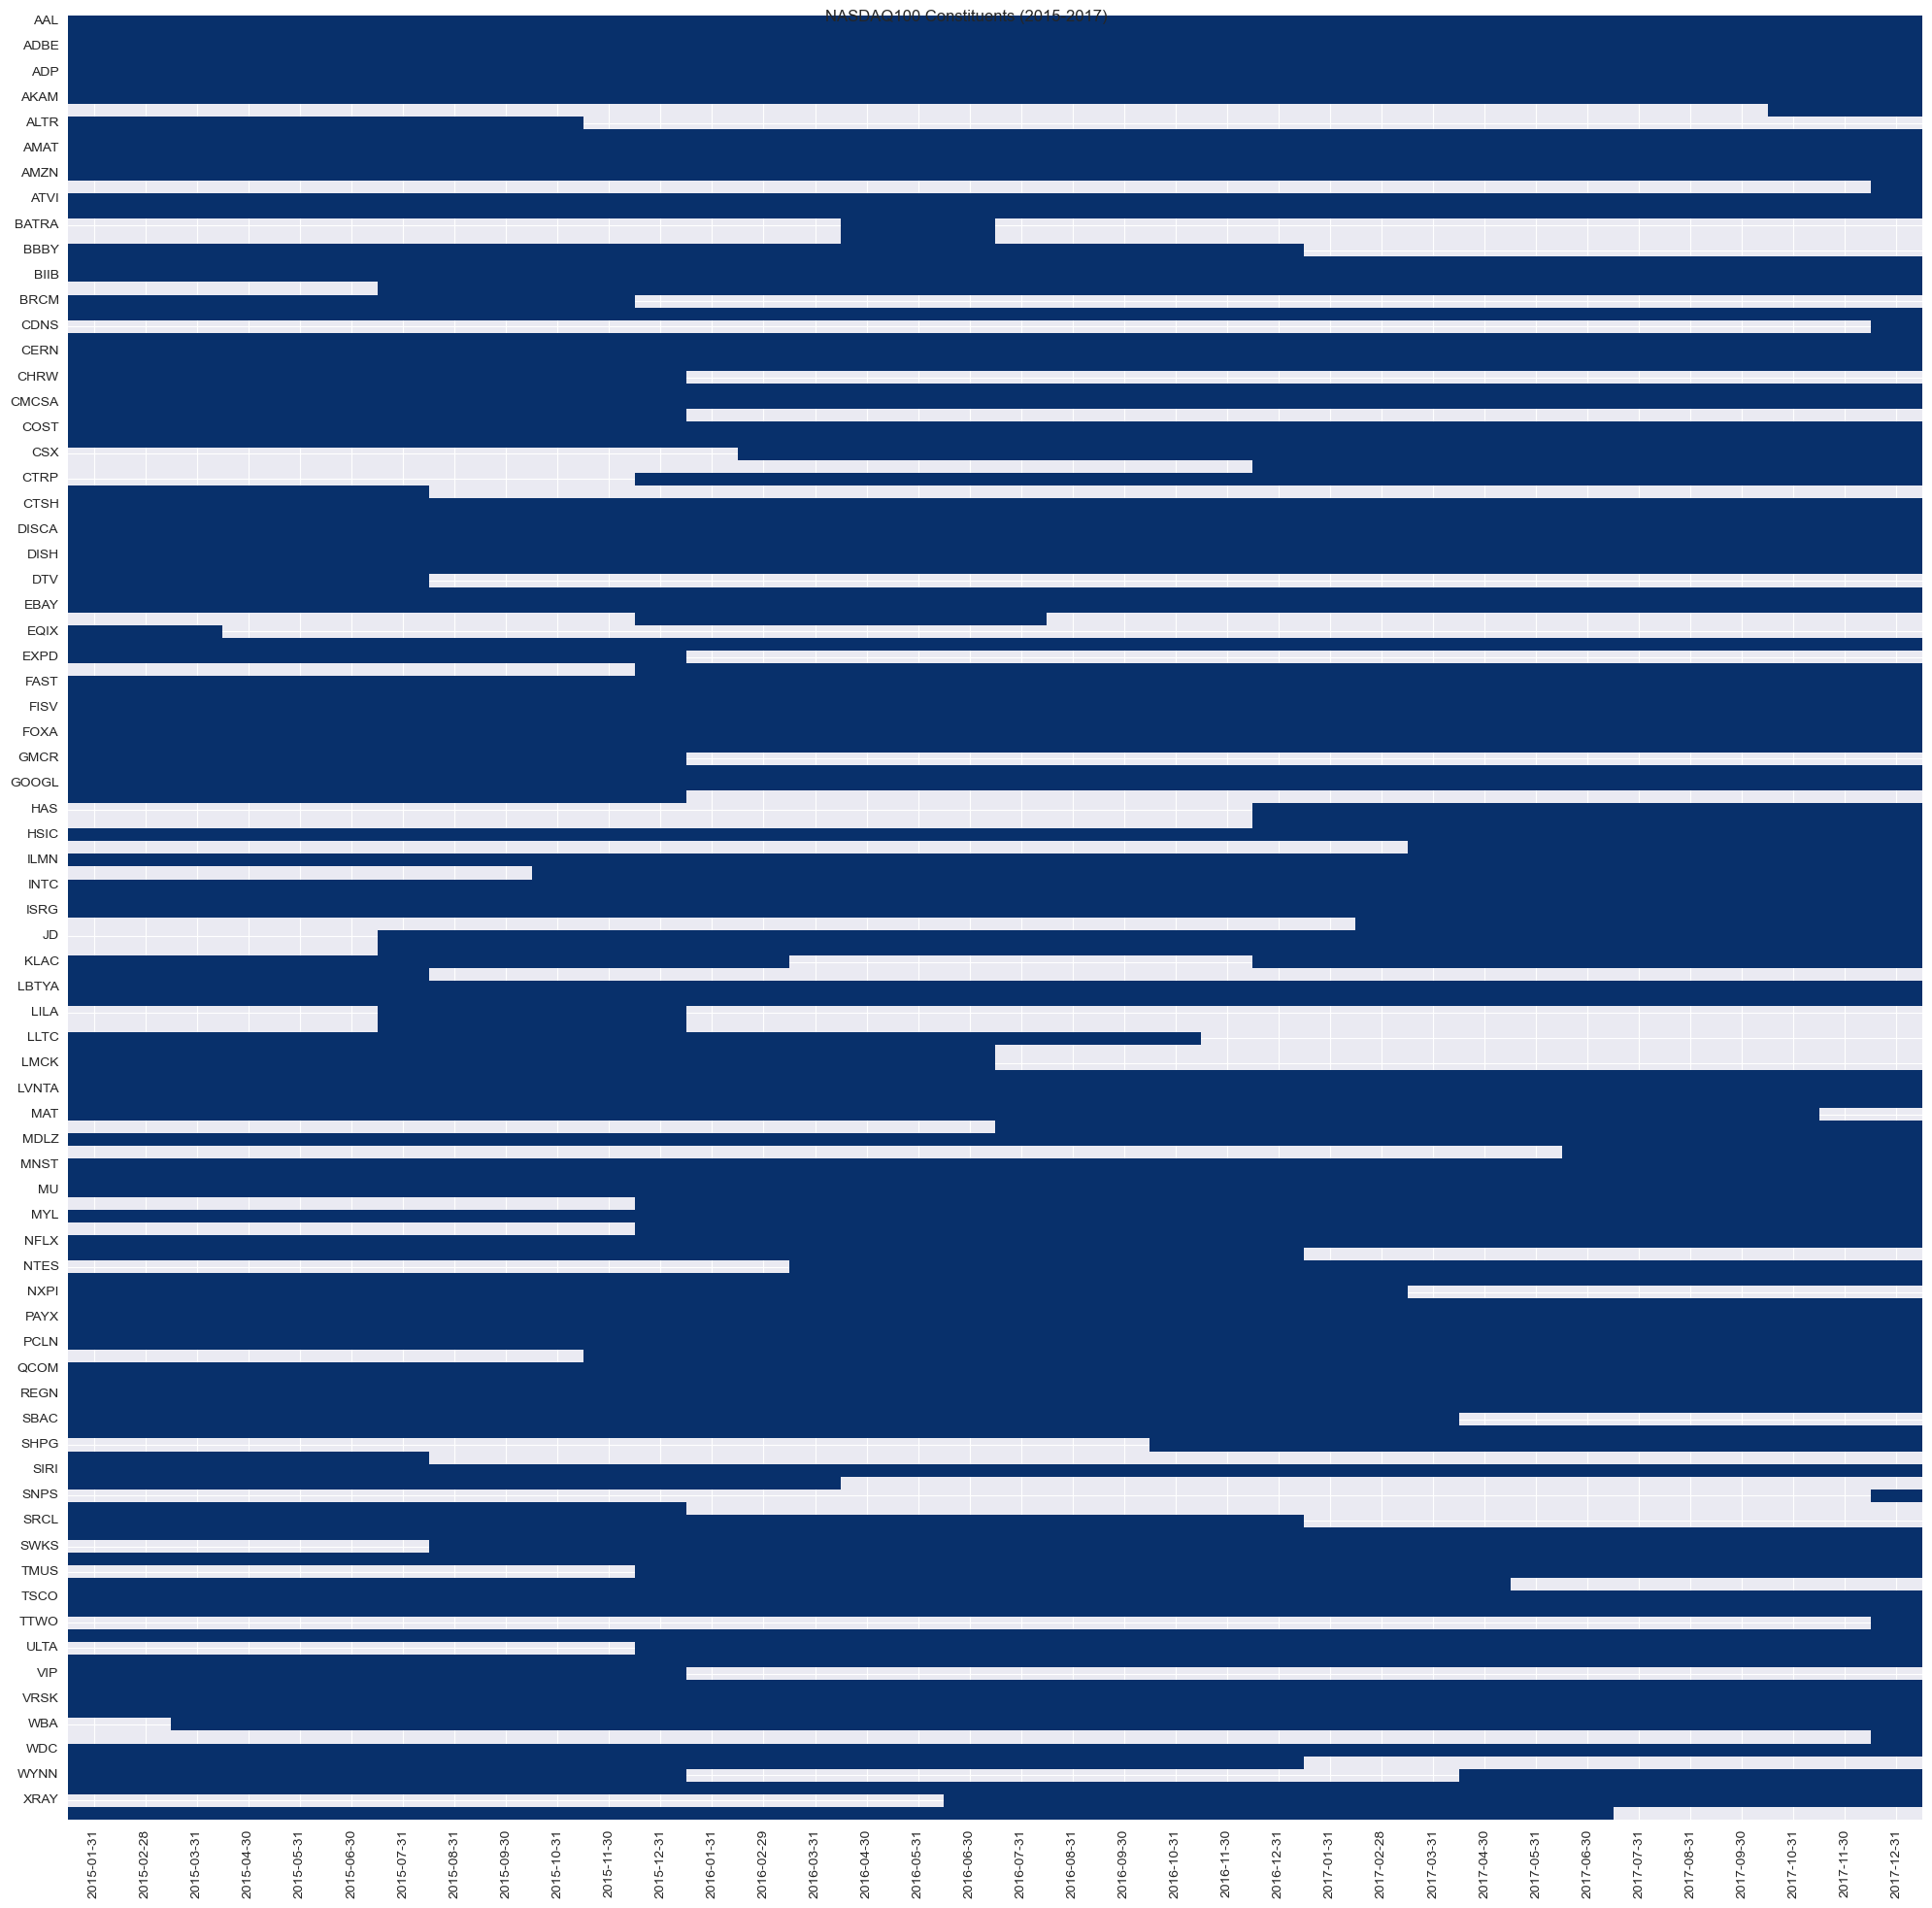

In [27]:
fig, ax = plt.subplots(figsize=(20, 20))
mask = constituents.T.isnull()
ax = sns.heatmap(constituents.T, mask=mask, cbar=False, ax=ax, cmap='Blues_r')
ax.set_ylabel('')
fig.suptitle('NASDAQ100 Constituents (2015-2017)')
fig.tight_layout();